In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import os

## Part 1: EDA

Read input data

In [2]:
shops = pd.read_csv("data/shops.csv")
item_categories = pd.read_csv("data/item_categories.csv")
sales_train = pd.read_csv("data/sales_train.csv")
items = pd.read_csv("data/items.csv")

test = pd.read_csv("data/test.csv")
sample_submission = pd.read_csv("data/sample_submission.csv")

Check duplicate items and null values

In [3]:
print("***** shops *****")
print(shops.nunique())
print("Duplicate: %d" % len(shops[shops.duplicated()]))
print(shops.isna().sum())
print("\n***** item_categories *****")
print(item_categories.nunique())
print("Duplicate: %d" % len(item_categories[item_categories.duplicated()]))
print(item_categories.isna().sum())
print("\n***** items *****")
print(items.nunique())
print("Duplicate: %d" % len(items[items.duplicated()]))
print(items.isna().sum())
print("\n***** sales_train *****")
print(sales_train.nunique())
print("Duplicate: %d" % len(sales_train[sales_train.duplicated()]))
print(sales_train.isna().sum())

***** shops *****
shop_name    60
shop_id      60
dtype: int64
Duplicate: 0
shop_name    0
shop_id      0
dtype: int64

***** item_categories *****
item_category_name    84
item_category_id      84
dtype: int64
Duplicate: 0
item_category_name    0
item_category_id      0
dtype: int64

***** items *****
item_name           22170
item_id             22170
item_category_id       84
dtype: int64
Duplicate: 0
item_name           0
item_id             0
item_category_id    0
dtype: int64

***** sales_train *****
date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
dtype: int64
Duplicate: 6
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64


There are some "duplicate" values in sales_train. Let's take a look

In [4]:
sales_train[sales_train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,05.01.2013,0,54,20130,149.0,1.0
1435367,23.02.2014,13,50,3423,999.0,1.0
1496766,23.03.2014,14,21,3423,999.0,1.0
1671873,01.05.2014,16,50,3423,999.0,1.0
1866340,12.07.2014,18,25,3423,999.0,1.0
2198566,31.12.2014,23,42,21619,499.0,1.0


These are NOT true "duplicates". There can be many people buying the same item on the same day.

In [5]:
print("\n***** test *****")
print(test.nunique())
print("Duplicate: %d" % len(test[test.duplicated()]))
print(test.isna().sum())


***** test *****
ID         214200
shop_id        42
item_id      5100
dtype: int64
Duplicate: 0
ID         0
shop_id    0
item_id    0
dtype: int64


Create lists for the item_id and shop_id to be predicted

In [6]:
item_id_test_list = list(test['item_id'].unique())
shop_id_test_list = list(test['shop_id'].unique())

Let's make a master dataframe containing all the information

In [7]:
train_master = sales_train.merge(items, on='item_id').merge(shops, on='shop_id').merge(item_categories, on='item_category_id')
train_master['city'] = train_master['shop_name'].str.split(' ').map(lambda x : x[0])
train_master.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,shop_name,item_category_name,city
0,02.01.2013,0,59,22154,999.0,1.0,ЯВЛЕНИЕ 2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль
1,26.04.2013,3,59,944,150.0,1.0,2012 (BD),37,"Ярославль ТЦ ""Альтаир""",Кино - Blu-Ray,Ярославль


### 1a. Total number of sold items vs. item_id

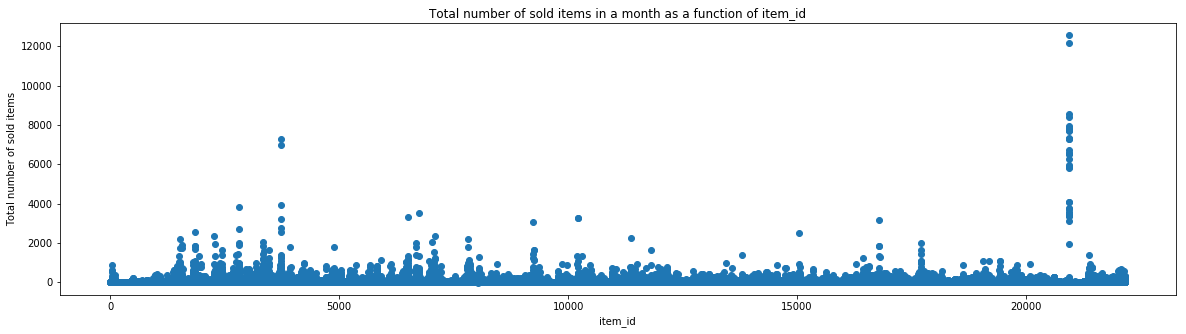

In [8]:
# First compute the total number of sold items for each item_id

df = sales_train.groupby(['date_block_num', 'item_id']).agg({'item_cnt_day' : ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

plt.figure(figsize=(20, 5))
plt.scatter(df.item_id, df.item_cnt_sum)
plt.title("Total number of sold items in a month as a function of item_id")
plt.xlabel("item_id")
plt.ylabel("Total number of sold items")
plt.show()

We found an "outlier"! There is one item that has been sold way more than others. Let's look into it.

In [9]:
id_max, total_item_max = df.item_cnt_sum.idxmax(), df.item_cnt_sum.max()
item_id_max = df.loc[id_max].item_id
print("The outlier item. item_id = %d; sold %d times" % (item_id_max, int(total_item_max)))

The outlier item. item_id = 20949; sold 12557 times


Let's check whether this item is in the test set

In [10]:
item_id_max in item_id_test_list

True

It is!

Then compute the total number of sold items for each item_id for each shop

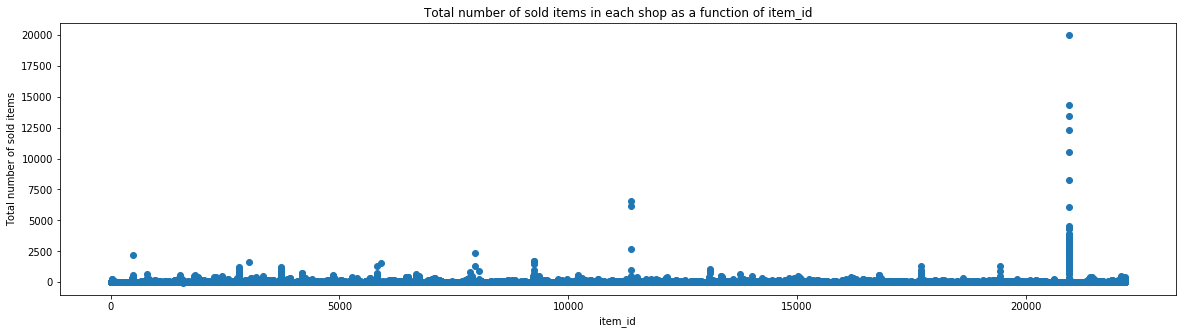

In [11]:
df = sales_train.groupby(['shop_id', 'item_id']).agg({'item_cnt_day' : ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

plt.figure(figsize=(20, 5))
plt.scatter(df.item_id, df.item_cnt_sum)
plt.title("Total number of sold items in each shop as a function of item_id")
plt.xlabel("item_id")
plt.ylabel("Total number of sold items")
plt.show()

We learn from the above plot that different shops lead to different sales.

### 1b. Total number of sold items vs. time

Let's use item_id = 20949 (the most sold item, or "outlier") as an example to look at how sales go with time

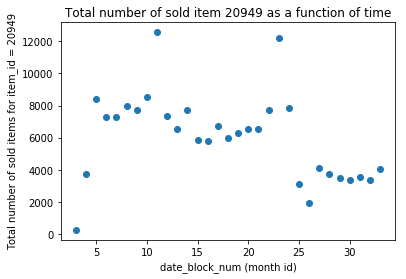

In [12]:
df = sales_train[sales_train.item_id == 20949].groupby(['date_block_num']).agg({'item_cnt_day' : ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

plt.scatter(df.date_block_num, df.item_cnt_sum)
plt.title("Total number of sold item 20949 as a function of time")
plt.xlabel("date_block_num (month id)")
plt.ylabel("Total number of sold items for item_id = 20949")
plt.show()

Looks good! So we keep this "outlier". This item is simply a popular one.

We see two peaks. Let's see what months are these

In [13]:
df[df.item_cnt_sum > 10000]

,date_block_num,item_cnt_sum
8,11,12557.0
20,23,12185.0


They are November!!!!! Keep in mind that we are trying to predict November as well

### Conclusion: item_id related features 
- item_id
- shop_id
- name of the item
- last 1, 2, 3, 6, 12 month's sale
- whether is on promotion

### 1c. Total number of sold items vs. item_category

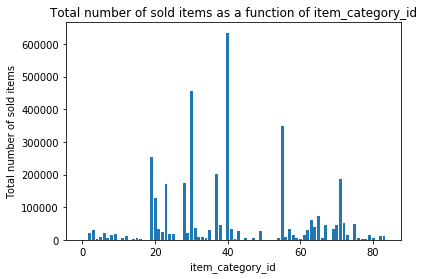

In [14]:
df = train_master.groupby(['item_category_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']
plt.bar(df.index, df.item_cnt_sum)
plt.title("Total number of sold items as a function of item_category_id")
plt.xlabel("item_category_id")
plt.ylabel("Total number of sold items")
plt.show()

Let's look at this plot as a function of time

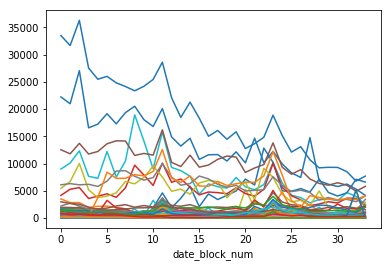

In [15]:
df = train_master.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']

df = df.unstack('item_category_id').loc[:].fillna(0)

df.plot(legend=False)

It looks like the economy is not doing well. The sale declined quite a bit as it approached 2015

Let's now try to compute the number of sold items vs item_category for different months, as a box plot

In [16]:
df = train_master.groupby(['date_block_num','item_category_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)
df.head(2)

,date_block_num,item_category_id,item_cnt_sum
0,0,0,1.0
1,0,1,1.0


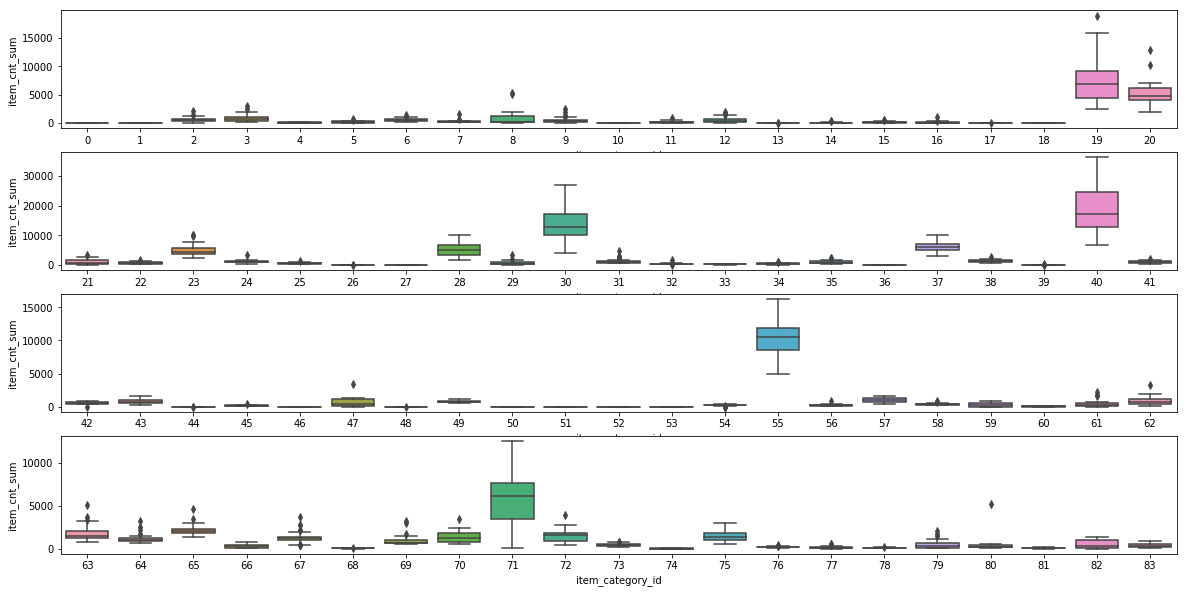

In [17]:
# Visualize the data

f, axes = plt.subplots(4, 1, figsize=(20,10))

for i in range(4):
    sns.boxplot(data=df[(df.item_category_id >= i * 21) & (df.item_category_id < (i + 1)*21)], 
                x='item_category_id', y='item_cnt_sum', ax=axes[i])

We found a few item categories that are extremely popular. Let's compute who they are

In [18]:
df = df.groupby(['item_category_id']).agg({'item_cnt_sum': ['median']})
df.columns = ['item_cnt_median']
df.sort_values('item_cnt_median',ascending=False, inplace=True)
df.reset_index(inplace=True)
df.head()

,item_category_id,item_cnt_median
0,40,17192.0
1,30,12715.0
2,55,10492.5
3,19,6846.5
4,71,6131.0


In [19]:
top_item_list = list(df[df.index < 10].item_category_id)
print("The top selling item categories are: \n")
print(top_item_list)

The top selling item categories are: 

[40, 30, 55, 19, 71, 37, 28, 20, 23, 65]


### Conclusion: category related features
- item_category_id
- last 1, 2, 3, 6, 12 month's sale for the same item_category_id

### 1d. Total number of sold items vs. shop_id

Compute the total number of sold items for each shop_id

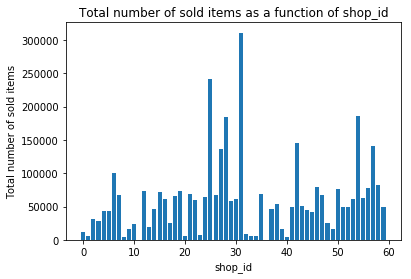

In [20]:
df = sales_train.groupby(['shop_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']

plt.bar(df.index, df.item_cnt_sum)
plt.title("Total number of sold items as a function of shop_id")
plt.xlabel("shop_id")
plt.ylabel("Total number of sold items")
plt.show()

There are a few shops that are doing great, and a few that are not doing so.

Let's make a correlation between sales and the city where the shop is in

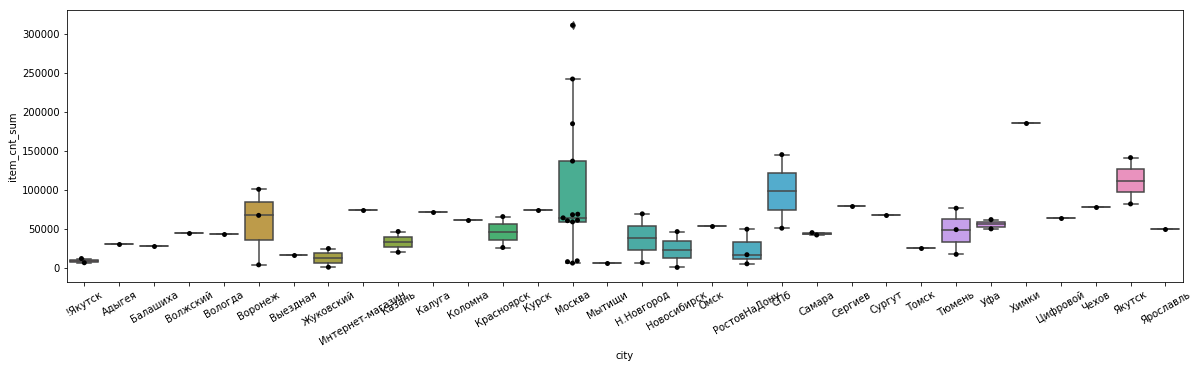

In [21]:
df = train_master.groupby(['city', 'shop_id']).agg({'item_cnt_day': ['sum']})
df.columns = ['item_cnt_sum']
df.reset_index(inplace=True)

f, ax = plt.subplots(1, 1, figsize=(20,5))
sns.boxplot(data=df, x='city', y='item_cnt_sum', ax=ax)
sns.swarmplot(data=df, x='city', y='item_cnt_sum', color='black', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show()

There is a slight correlation between city and the sales. BTW, The city in the middle of the above box plot is Moscow!

### Conclusion: shop related features
- shop_id
- city
- last 1, 2, 3, 6, 12 month's shop revenue

### 1e. Price Histogram

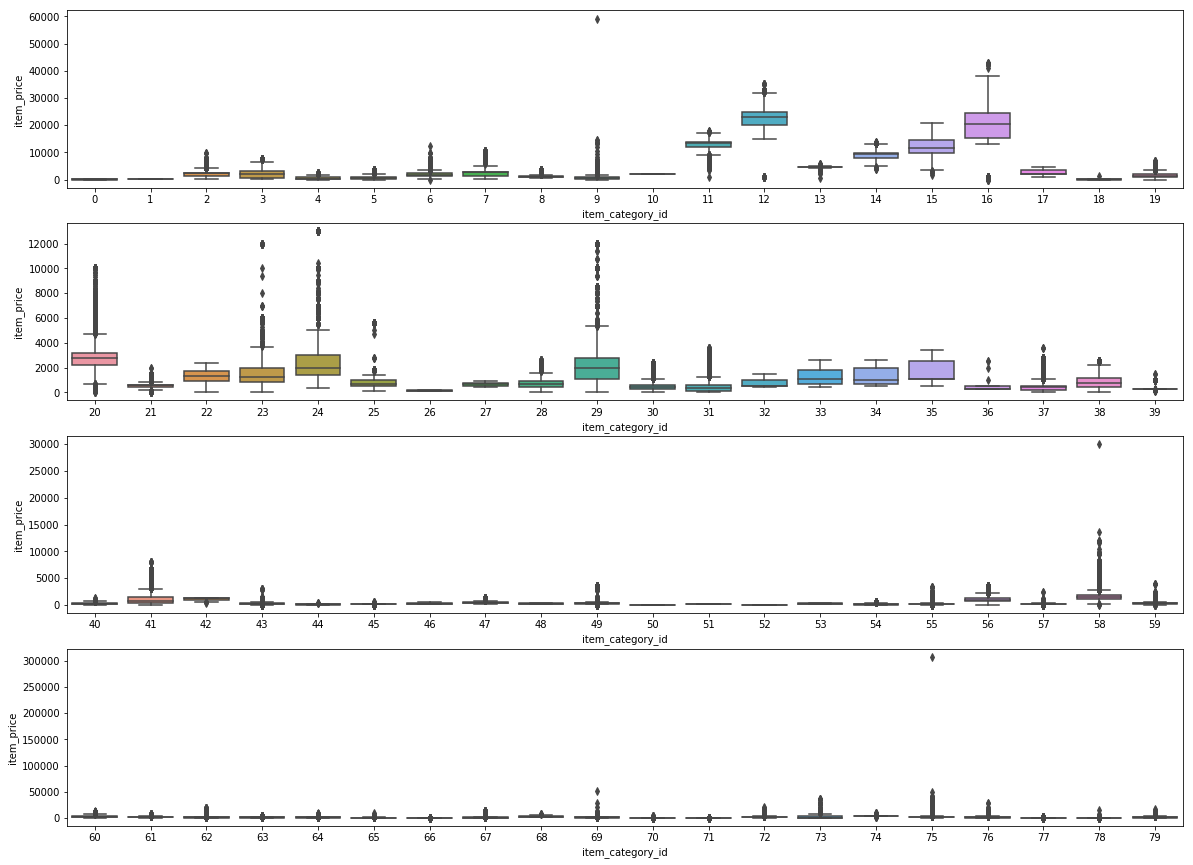

In [22]:
f, axes = plt.subplots(4, 1, figsize=(20,15))

for i in range(4):
    sns.boxplot(data=train_master[(train_master.item_category_id >= i * 20) & (train_master.item_category_id < (i + 1)*20)], 
                x='item_category_id', y='item_price', ax=axes[i])

### 1f. Price correlation with Sales

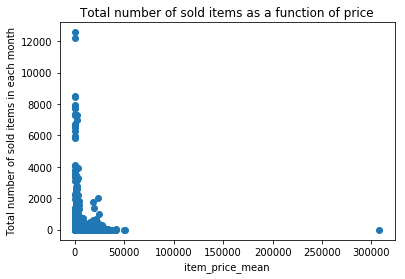

In [23]:
df = train_master.groupby(['date_block_num', 'item_id']).agg({'item_price':['median'],'item_cnt_day':['sum']})
df.columns = ['item_price_mean', 'item_cnt_sum']
df.reset_index(inplace=True)

plt.scatter(df.item_price_mean, df.item_cnt_sum)
plt.title("Total number of sold items as a function of price")
plt.xlabel("item_price_mean")
plt.ylabel("Total number of sold items in each month")
plt.show()

There is one "outlier" on the right. let's take a closer look into the left part by zooming in

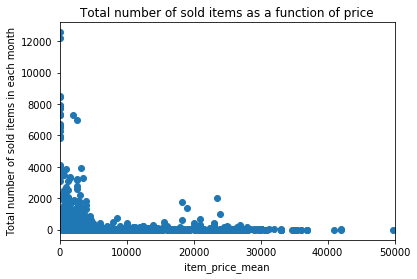

In [24]:
plt.scatter(df.item_price_mean, df.item_cnt_sum)
plt.title("Total number of sold items as a function of price")
plt.xlabel("item_price_mean")
plt.ylabel("Total number of sold items in each month")
plt.xlim([0, 50000])
plt.show()

Looks like a Pareto plot! It makes a lot of sense. The price can be a powerful feature in predicting the sales

### Conclusion: price related features
- item_price
- last 1, 2, 3, 6, 12 month's item_price

### 1g. Outdated Items

Compute items that are not sold in the last twelve months

In [25]:
df = sales_train.pivot_table(index=['item_id'],values=['item_cnt_day'], 
                            columns='date_block_num', aggfunc=np.sum, fill_value=0).reset_index()
df.columns = df.columns.droplevel().map(str)
df = df.reset_index(drop=True).rename_axis(None, axis=1)
df.columns.values[0] = 'item_id'

outdated_items = list(df[df.loc[:, '22':].sum(axis=1)==0]['item_id'])
print("There are %d outdated items" % len(outdated_items))

There are 9638 outdated items


That's a lot!!! Since items are outdated, we can just put ZERO into the prediction of these items.

### Conclusion: outdatedness related features
- whether the item is outdated

# Part 2: Data Pre-Processing

Stack the train and test data together

In [26]:
test['date_block_num'] = 34
train_test = sales_train.append(test.drop(columns=['ID']))
train_test.tail(2)

C:\Users\ChenP\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


,date,date_block_num,item_cnt_day,item_id,item_price,shop_id
214198,NaN,34,NaN,19648,NaN,45
214199,NaN,34,NaN,969,NaN,45


### 2a. Feature Engineering

Aggregate sales to monthly level and clip the value, and also join with other features

In [27]:
# Aggregate sales to monthly level
train_master = train_test.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})
train_master.columns = ['item_cnt_sum']
train_master.reset_index(inplace=True)
train_master['item_cnt_sum'] = np.clip(train_master['item_cnt_sum'], 0, 20)

# Attach the item_category_id, shop_id, shop_name columns
train_master = train_master.merge(items[['item_id','item_category_id']], on='item_id', how='left')
train_master = train_master.merge(shops, on='shop_id', how='left')
train_master = train_master.merge(item_categories[['item_category_id']], on='item_category_id', how='left')

train_master.head(2)

,date_block_num,shop_id,item_id,item_cnt_sum,item_category_id,shop_name
0,0,0,32,6.0,40,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,3.0,37,"!Якутск Орджоникидзе, 56 фран"


Notice that we do not have all the (date_block_num, shop_id, item_id) pairs, if the sales = 0. Therefore, we need to fill in the missing pairs.

In [28]:
from itertools import product

months = train_master[train_master.date_block_num <= 33]['date_block_num'].unique()

cartesian = []
for month in months:
    shops_in_month = train_master.loc[train_master['date_block_num']==month, 'shop_id'].unique()
    items_in_month = train_master.loc[train_master['date_block_num']==month, 'item_id'].unique()
    cartesian.append(np.array(list(product(*[shops_in_month, items_in_month, [month]])), dtype='int32'))
    
cartesian_df = pd.DataFrame(np.vstack(cartesian), columns = ['shop_id', 'item_id', 'date_block_num'], dtype=np.int32)
print(cartesian_df.shape)

(10913850, 3)


The generated cartesian_df dataframe will contain all the unique (shop_id, item_id, date_block_num) pairs

Append the test set into the cartesian_df

In [29]:
test['date_block_num'] = 34
cartesian_df = cartesian_df.append(test.drop(columns=['ID']))

We merge it back to the train dataframe and fill NaN with zeros to include zeros in the sales record

In [30]:
new_train = cartesian_df.merge(train_master[['date_block_num','shop_id', 'item_id','item_cnt_sum']], 
                               on=['date_block_num','shop_id','item_id'], how='left').fillna(0)
new_train.head()

,shop_id,item_id,date_block_num,item_cnt_sum
0,0,32,0,6.0
1,0,33,0,3.0
2,0,35,0,1.0
3,0,43,0,1.0
4,0,51,0,2.0


Append feature columns and deduce the city feature from the shop name

In [31]:
# Attach the item_category_id, shop_id, shop_name columns
new_train = new_train.merge(items[['item_id','item_category_id']], on='item_id', how='left')
new_train = new_train.merge(shops, on='shop_id', how='left')
new_train = new_train.merge(item_categories[['item_category_id']], on='item_category_id', how='left')

# find the city attribute from the first word of the shop name
new_train['city'] = new_train['shop_name'].str.split(' ').map(lambda x : x[0])
new_train.drop(columns=['shop_name'], inplace=True)
new_train.reset_index(drop=True, inplace=True)

new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city
0,0,32,0,6.0,40,!Якутск
1,0,33,0,3.0,37,!Якутск


### 2b. Add features: item_id related features <br>
- item_id
- shop_id
- last 1, 2, 3, 6, 12 month's sale for the same item_id in the same shop_id
- last 1, 2, 3, 6, 12 month's mean sale for the same item_id in all shops

First create a function to add lag feature more easily

In [32]:
def lag_feature(df, df_shift, lags, on, col):
    tmp = df_shift[on + [col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = on + [col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = df.merge(shifted, on=on, how='left')
    return df

Then, lag the target variable

In [33]:
new_train = lag_feature(new_train, new_train, lags=[1,2,3,6,12], on=['date_block_num','shop_id','item_id'], col='item_cnt_sum')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12
0,0,32,0,6.0,40,!Якутск,NaN,NaN,NaN,NaN,NaN
1,0,33,0,3.0,37,!Якутск,NaN,NaN,NaN,NaN,NaN


To lag the mean item_cnt_sum for the same item_id over all shops, we first compute the average and then lag

In [34]:
df = train_master.groupby(['date_block_num', 'item_id']).agg({'item_cnt_sum':['mean']})
df.columns = ['item_cnt_sum_avg_by_shop']
df.reset_index(inplace=True)

new_train = lag_feature(new_train, df, lags=[1,2,3,6,12], on=['date_block_num','item_id'], col='item_cnt_sum_avg_by_shop')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12,item_cnt_sum_avg_by_shop_lag_1,item_cnt_sum_avg_by_shop_lag_2,item_cnt_sum_avg_by_shop_lag_3,item_cnt_sum_avg_by_shop_lag_6,item_cnt_sum_avg_by_shop_lag_12
0,0,32,0,6.0,40,!Якутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,33,0,3.0,37,!Якутск,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3c. Add features: Categorical related features <br>
- item_category_id
- last 1, 2, 3, 6, 12 months' sale for items with the same item_category_id in the same shop
- last 1, 2, 3, 6, 12 months' sale for items with the same item_category_id averaged among all shops

In [35]:
df = train_master.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_sum':['mean']})
df.columns = ['item_cnt_sum_avg_by_cat']
df.reset_index(inplace=True)

new_train = lag_feature(new_train, df, lags=[1,2,3,6,12], 
                        on=['date_block_num','shop_id','item_category_id'], col='item_cnt_sum_avg_by_cat')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_6,...,item_cnt_sum_avg_by_shop_lag_1,item_cnt_sum_avg_by_shop_lag_2,item_cnt_sum_avg_by_shop_lag_3,item_cnt_sum_avg_by_shop_lag_6,item_cnt_sum_avg_by_shop_lag_12,item_cnt_sum_avg_by_cat_lag_1,item_cnt_sum_avg_by_cat_lag_2,item_cnt_sum_avg_by_cat_lag_3,item_cnt_sum_avg_by_cat_lag_6,item_cnt_sum_avg_by_cat_lag_12
0,0,32,0,6.0,40,!Якутск,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,33,0,3.0,37,!Якутск,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
df = train_master.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_sum':['mean']})
df.columns = ['item_cnt_sum_avg_by_cat_by_shop']
df.reset_index(inplace=True)

new_train = lag_feature(new_train, df, lags=[1,2,3,6,12], 
                        on=['date_block_num','item_category_id'], col='item_cnt_sum_avg_by_cat_by_shop')
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,city,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_6,...,item_cnt_sum_avg_by_cat_lag_1,item_cnt_sum_avg_by_cat_lag_2,item_cnt_sum_avg_by_cat_lag_3,item_cnt_sum_avg_by_cat_lag_6,item_cnt_sum_avg_by_cat_lag_12,item_cnt_sum_avg_by_cat_by_shop_lag_1,item_cnt_sum_avg_by_cat_by_shop_lag_2,item_cnt_sum_avg_by_cat_by_shop_lag_3,item_cnt_sum_avg_by_cat_by_shop_lag_6,item_cnt_sum_avg_by_cat_by_shop_lag_12
0,0,32,0,6.0,40,!Якутск,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,33,0,3.0,37,!Якутск,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2d. Add features: month and city label

Add a month feature

In [37]:
new_train['month'] = new_train['date_block_num'] % 12

Label encode the categorical variables

In [38]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
new_train['city_label'] = le.fit_transform(new_train['city'])
new_train.drop(['city'], axis = 1, inplace=True)
new_train.head(2)

,shop_id,item_id,date_block_num,item_cnt_sum,item_category_id,item_cnt_sum_lag_1,item_cnt_sum_lag_2,item_cnt_sum_lag_3,item_cnt_sum_lag_6,item_cnt_sum_lag_12,...,item_cnt_sum_avg_by_cat_lag_3,item_cnt_sum_avg_by_cat_lag_6,item_cnt_sum_avg_by_cat_lag_12,item_cnt_sum_avg_by_cat_by_shop_lag_1,item_cnt_sum_avg_by_cat_by_shop_lag_2,item_cnt_sum_avg_by_cat_by_shop_lag_3,item_cnt_sum_avg_by_cat_by_shop_lag_6,item_cnt_sum_avg_by_cat_by_shop_lag_12,month,city_label
0,0,32,0,6.0,40,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,0,33,0,3.0,37,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


### 2e. Save the dataset

In [39]:
new_train.to_pickle('train_test.pkl')

del cartesian_df
del items
del shops
del sales_train
del train_master
del train_test

In [40]:
import gc

gc.collect()

167

## Part 3: Train an XGBoost model

In [4]:
new_train = pd.read_pickle('train_test.pkl')

### 3a. Set up an XGBoost model and perform hyperparameter tuning

In [5]:
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse

- We use a coarse grid to do hyperparameter tuning
- Train: date_block_num = [12, 32]; Validation: date_block_num = 33

In [6]:
x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 32)]
x_val = new_train[new_train.date_block_num == 33]
    
y_train = x_train[['item_cnt_sum']]
y_val = x_val[['item_cnt_sum']]
x_train = x_train.drop(columns=['item_cnt_sum']).fillna(0)
x_val = x_val.drop(columns=['item_cnt_sum']).fillna(0)

The dataset is too large for gridsearchcv, so we do the hyperparameter search using for loops

In [46]:
min_child_weight_list = [10, 100, 300]

for min_child_weight in min_child_weight_list:

    print("******************* %4d *******************\n\n" % min_child_weight)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=min_child_weight, 
                         colsample_bytree=0.8, 
                         subsample=0.8,
                         eta=0.3,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n min_child_weight %4d, RMSE: %.3f' % (min_child_weight, score))

*******************   10 *******************


[21:14:40] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15726	validation_1-rmse:1.12433
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11458	validation_1-rmse:1.09425
[2]	validation_0-rmse:1.07374	validation_1-rmse:1.06485
[3]	validation_0-rmse:1.0386	validation_1-rmse:1.0409
[4]	validation_0-rmse:1.01136	validation_1-rmse:1.02041
[5]	validation_0-rmse:0.985414	validation_1-rmse:1.00165
[6]	validation_0-rmse:0.964917	validation_1-rmse:0.989031
[7]	validation_0-rmse:0.947471	validation_1-rmse:0.978084
[8]	validation_0-rmse:0.932755	validation_1-rmse:0.968874
[9]	validation_0-rmse:0.918151	validation_1-rmse:0.959893
[10]	validation_0-rmse:0.906066	validation_1-rmse:0.952

[34]	validation_0-rmse:0.834219	validation_1-rmse:0.914566
[35]	validation_0-rmse:0.833321	validation_1-rmse:0.915373
[36]	validation_0-rmse:0.832421	validation_1-rmse:0.915445
[37]	validation_0-rmse:0.831604	validation_1-rmse:0.91546
[38]	validation_0-rmse:0.830399	validation_1-rmse:0.915349
[39]	validation_0-rmse:0.829853	validation_1-rmse:0.915233
[40]	validation_0-rmse:0.829256	validation_1-rmse:0.91537
[41]	validation_0-rmse:0.828814	validation_1-rmse:0.915407
[42]	validation_0-rmse:0.828189	validation_1-rmse:0.915177
[43]	validation_0-rmse:0.827532	validation_1-rmse:0.915556
[44]	validation_0-rmse:0.826678	validation_1-rmse:0.915609
Stopping. Best iteration:
[34]	validation_0-rmse:0.834219	validation_1-rmse:0.914566



 min_child_weight  300, RMSE: 0.915


In [47]:
colsample_bytree_list = [0.5, 0.6, 0.7, 0.8]

for colsample_bytree in colsample_bytree_list:

    print("******************* %.1f *******************\n\n" % colsample_bytree)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=100, 
                         colsample_bytree=colsample_bytree, 
                         subsample=0.8,
                         eta=0.3,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n colsample_bytree %.1f, RMSE: %.3f' % (colsample_bytree, score))

******************* 0.5 *******************


[23:24:44] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15861	validation_1-rmse:1.12417
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11774	validation_1-rmse:1.0938
[2]	validation_0-rmse:1.08238	validation_1-rmse:1.06755
[3]	validation_0-rmse:1.05187	validation_1-rmse:1.04703
[4]	validation_0-rmse:1.02847	validation_1-rmse:1.03057
[5]	validation_0-rmse:1.0019	validation_1-rmse:1.01314
[6]	validation_0-rmse:0.984646	validation_1-rmse:1.00073
[7]	validation_0-rmse:0.969105	validation_1-rmse:0.989176
[8]	validation_0-rmse:0.953708	validation_1-rmse:0.978258
[9]	validation_0-rmse:0.936907	validation_1-rmse:0.967726
[10]	validation_0-rmse:0.922644	validation_1-rmse:0.958866

[16]	validation_0-rmse:0.867625	validation_1-rmse:0.931934
[17]	validation_0-rmse:0.862863	validation_1-rmse:0.929462
[18]	validation_0-rmse:0.858711	validation_1-rmse:0.927994
[19]	validation_0-rmse:0.855021	validation_1-rmse:0.926024
[20]	validation_0-rmse:0.852207	validation_1-rmse:0.924336
[21]	validation_0-rmse:0.849066	validation_1-rmse:0.922208
[22]	validation_0-rmse:0.846307	validation_1-rmse:0.921382
[23]	validation_0-rmse:0.843616	validation_1-rmse:0.920174
[24]	validation_0-rmse:0.841427	validation_1-rmse:0.919337
[25]	validation_0-rmse:0.839848	validation_1-rmse:0.918507
[26]	validation_0-rmse:0.837952	validation_1-rmse:0.917466
[27]	validation_0-rmse:0.836547	validation_1-rmse:0.916803
[28]	validation_0-rmse:0.83507	validation_1-rmse:0.91648
[29]	validation_0-rmse:0.83361	validation_1-rmse:0.916058
[30]	validation_0-rmse:0.831847	validation_1-rmse:0.914858
[31]	validation_0-rmse:0.830437	validation_1-rmse:0.914786
[32]	validation_0-rmse:0.829269	validation_1-rmse:0.914736


In [7]:
subsample_list = [0.6, 0.7, 0.8, 0.9]

for subsample in subsample_list:

    print("******************* %.1f *******************\n\n" % subsample)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=100, 
                         colsample_bytree=0.7, 
                         subsample=subsample,
                         eta=0.3,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n subsample %.1f, RMSE: %.3f' % (subsample, score))

******************* 0.6 *******************


[19:59:33] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15766	validation_1-rmse:1.12426
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11617	validation_1-rmse:1.09351
[2]	validation_0-rmse:1.0799	validation_1-rmse:1.06815
[3]	validation_0-rmse:1.0446	validation_1-rmse:1.04423
[4]	validation_0-rmse:1.01797	validation_1-rmse:1.02628
[5]	validation_0-rmse:0.991225	validation_1-rmse:1.00775
[6]	validation_0-rmse:0.971416	validation_1-rmse:0.99592
[7]	validation_0-rmse:0.954423	validation_1-rmse:0.984456
[8]	validation_0-rmse:0.940499	validation_1-rmse:0.974616
[9]	validation_0-rmse:0.925622	validation_1-rmse:0.965159
[10]	validation_0-rmse:0.913173	validation_1-rmse:0.95657

[14]	validation_0-rmse:0.879097	validation_1-rmse:0.938517
[15]	validation_0-rmse:0.87314	validation_1-rmse:0.935854
[16]	validation_0-rmse:0.867625	validation_1-rmse:0.931934
[17]	validation_0-rmse:0.862863	validation_1-rmse:0.929462
[18]	validation_0-rmse:0.858711	validation_1-rmse:0.927994
[19]	validation_0-rmse:0.855021	validation_1-rmse:0.926024
[20]	validation_0-rmse:0.852207	validation_1-rmse:0.924336
[21]	validation_0-rmse:0.849066	validation_1-rmse:0.922208
[22]	validation_0-rmse:0.846307	validation_1-rmse:0.921382
[23]	validation_0-rmse:0.843616	validation_1-rmse:0.920174
[24]	validation_0-rmse:0.841427	validation_1-rmse:0.919337
[25]	validation_0-rmse:0.839848	validation_1-rmse:0.918507
[26]	validation_0-rmse:0.837952	validation_1-rmse:0.917466
[27]	validation_0-rmse:0.836547	validation_1-rmse:0.916803
[28]	validation_0-rmse:0.83507	validation_1-rmse:0.91648
[29]	validation_0-rmse:0.83361	validation_1-rmse:0.916058
[30]	validation_0-rmse:0.831847	validation_1-rmse:0.914858
[

In [8]:
eta_list = [0.1, 0.3, 0.5]

for eta in eta_list:

    print("******************* %.1f *******************\n\n" % eta)
    
    model = XGBRegressor(n_estimators=200,
                         max_depth=8,
                         min_child_weight=100, 
                         colsample_bytree=0.7, 
                         subsample=0.8,
                         eta=eta,
                         seed=42)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    
    print('\n\n eta %.1f, RMSE: %.3f' % (eta, score))

******************* 0.1 *******************


[22:57:37] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15758	validation_1-rmse:1.12397
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11528	validation_1-rmse:1.09407
[2]	validation_0-rmse:1.07909	validation_1-rmse:1.06838
[3]	validation_0-rmse:1.04365	validation_1-rmse:1.04378
[4]	validation_0-rmse:1.01706	validation_1-rmse:1.02565
[5]	validation_0-rmse:0.99038	validation_1-rmse:1.00721
[6]	validation_0-rmse:0.970399	validation_1-rmse:0.995158
[7]	validation_0-rmse:0.953493	validation_1-rmse:0.984221
[8]	validation_0-rmse:0.939279	validation_1-rmse:0.975105
[9]	validation_0-rmse:0.924	validation_1-rmse:0.964885
[10]	validation_0-rmse:0.911481	validation_1-rmse:0.956636

[4]	validation_0-rmse:1.01706	validation_1-rmse:1.02565
[5]	validation_0-rmse:0.99038	validation_1-rmse:1.00721
[6]	validation_0-rmse:0.970399	validation_1-rmse:0.995158
[7]	validation_0-rmse:0.953493	validation_1-rmse:0.984221
[8]	validation_0-rmse:0.939279	validation_1-rmse:0.975105
[9]	validation_0-rmse:0.924	validation_1-rmse:0.964885
[10]	validation_0-rmse:0.911481	validation_1-rmse:0.956636
[11]	validation_0-rmse:0.900845	validation_1-rmse:0.950446
[12]	validation_0-rmse:0.892135	validation_1-rmse:0.945465
[13]	validation_0-rmse:0.88464	validation_1-rmse:0.942099
[14]	validation_0-rmse:0.879097	validation_1-rmse:0.938517
[15]	validation_0-rmse:0.87314	validation_1-rmse:0.935854
[16]	validation_0-rmse:0.867625	validation_1-rmse:0.931934
[17]	validation_0-rmse:0.862863	validation_1-rmse:0.929462
[18]	validation_0-rmse:0.858711	validation_1-rmse:0.927994
[19]	validation_0-rmse:0.855021	validation_1-rmse:0.926024
[20]	validation_0-rmse:0.852207	validation_1-rmse:0.924336
[21]	validat

### 3b. Train/Test Split and K-Fold Cross Validation

It is a little bit tricky to perform k-fold cross validation for time series analysis. We adopt the idea from sklearn.model_selection.TimeSeriesSplit and split the training set into follows <br>
- Fold 1: Train: date_block_num = [12, 28]; Validation: date_block_num = 29
- Fold 2: Train: date_block_num = [12, 29]; Validation: date_block_num = 30
- Fold 3: Train: date_block_num = [12, 30]; Validation: date_block_num = 31
- Fold 4: Train: date_block_num = [12, 31]; Validation: date_block_num = 32
- Fold 5: Train: date_block_num = [12, 32]; Validation: date_block_num = 33

In [6]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=8,
    min_child_weight=100, 
    colsample_bytree=0.7, 
    subsample=0.8,
    eta=0.3,    
    seed=42)

x_test = new_train[new_train.date_block_num == 34]
x_test = new_train[new_train.date_block_num == 34]
x_test = x_test.drop(columns=['item_cnt_sum']).fillna(0)

# k-fold = 5
k = 5

scores = []
for i in range(k):
    
    # Split the train and evaluation set
    x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 33-k+i)]
    x_val = new_train[new_train.date_block_num == 33-k+i+1]
    
    y_train = x_train[['item_cnt_sum']]
    y_val = x_val[['item_cnt_sum']]
    x_train = x_train.drop(columns=['item_cnt_sum']).fillna(0)
    x_val = x_val.drop(columns=['item_cnt_sum']).fillna(0)
    
    # Fit the model
    model.fit(
        x_train, 
        y_train, 
        eval_metric="rmse", 
        eval_set=[(x_train, y_train), (x_val, y_val)], 
        verbose=True,
        early_stopping_rounds = 10)
    
    # Evaluate the model
    score = np.sqrt(mse(y_val, model.predict(x_val)))
    scores.append(score)
    
    print('Fold %2d, RMSE: %.3f' % (i, score))
    
print('\n CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

[14:51:27] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.18118	validation_1-rmse:1.0472
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1326	validation_1-rmse:1.00421
[2]	validation_0-rmse:1.09157	validation_1-rmse:0.968289
[3]	validation_0-rmse:1.05899	validation_1-rmse:0.943762
[4]	validation_0-rmse:1.03034	validation_1-rmse:0.919475
[5]	validation_0-rmse:1.00338	validation_1-rmse:0.896625
[6]	validation_0-rmse:0.980567	validation_1-rmse:0.877178
[7]	validation_0-rmse:0.961758	validation_1-rmse:0.863353
[8]	validation_0-rmse:0.944984	validation_1-rmse:0.851167
[9]	validation_0-rmse:0.930892	validation_1-rmse:0.840843
[10]	validation_0-rmse:0.918402	validation_1-rmse:0.831701
[11]	validation_0-rmse:0.90828	validatio

[0]	validation_0-rmse:1.15873	validation_1-rmse:1.04088
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.11262	validation_1-rmse:1.00342
[2]	validation_0-rmse:1.07335	validation_1-rmse:0.971092
[3]	validation_0-rmse:1.04139	validation_1-rmse:0.944854
[4]	validation_0-rmse:1.01287	validation_1-rmse:0.921152
[5]	validation_0-rmse:0.987665	validation_1-rmse:0.901296
[6]	validation_0-rmse:0.966732	validation_1-rmse:0.884506
[7]	validation_0-rmse:0.952336	validation_1-rmse:0.87184
[8]	validation_0-rmse:0.936649	validation_1-rmse:0.859314
[9]	validation_0-rmse:0.922514	validation_1-rmse:0.847088
[10]	validation_0-rmse:0.910569	validation_1-rmse:0.837188
[11]	validation_0-rmse:0.900617	validation_1-rmse:0.828675
[12]	validation_0-rmse:0.892316	validation_1-rmse:0.822088
[13]	validation_0-rmse:0.884618	validation_1-rmse:0.815867
[14]	validation_0-rmse:0.878005	v

[49]	validation_0-rmse:0.810865	validation_1-rmse:0.882864
[50]	validation_0-rmse:0.810137	validation_1-rmse:0.882731
[51]	validation_0-rmse:0.809081	validation_1-rmse:0.882734
[52]	validation_0-rmse:0.808598	validation_1-rmse:0.882522
[53]	validation_0-rmse:0.808088	validation_1-rmse:0.882451
[54]	validation_0-rmse:0.807413	validation_1-rmse:0.881982
[55]	validation_0-rmse:0.806961	validation_1-rmse:0.881903
[56]	validation_0-rmse:0.806281	validation_1-rmse:0.882033
[57]	validation_0-rmse:0.804707	validation_1-rmse:0.881928
[58]	validation_0-rmse:0.804298	validation_1-rmse:0.882055
[59]	validation_0-rmse:0.803651	validation_1-rmse:0.881978
[60]	validation_0-rmse:0.802249	validation_1-rmse:0.882624
[61]	validation_0-rmse:0.801821	validation_1-rmse:0.88276
[62]	validation_0-rmse:0.801011	validation_1-rmse:0.882258
[63]	validation_0-rmse:0.800712	validation_1-rmse:0.882108
[64]	validation_0-rmse:0.800225	validation_1-rmse:0.882714
[65]	validation_0-rmse:0.79975	validation_1-rmse:0.882591

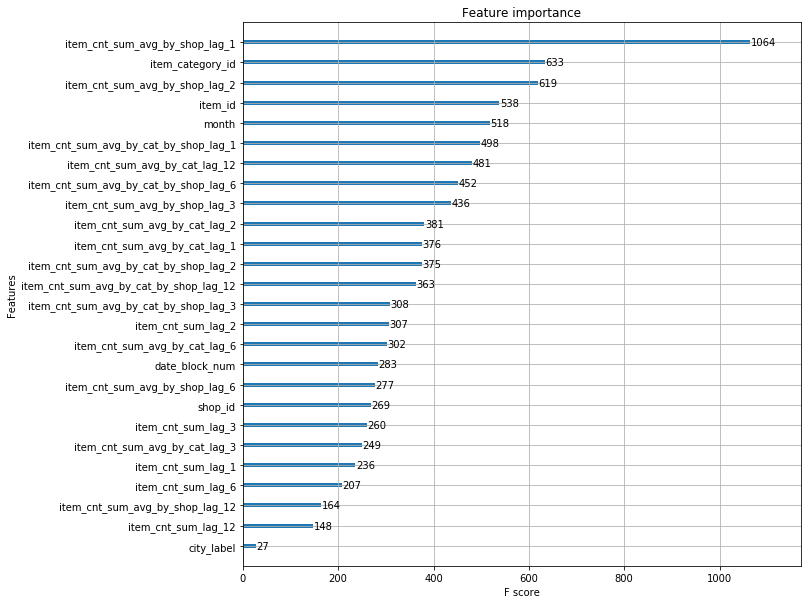

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))
plot_importance(booster=model, ax=ax)

Now, we put all the training data together and train the final model

In [9]:
x_train = new_train[(new_train.date_block_num >= 12) & (new_train.date_block_num <= 33)]
y_train = x_train[['item_cnt_sum']]
x_train = x_train.drop(columns=['item_cnt_sum']).fillna(0)

x_test = new_train[new_train.date_block_num == 34].drop(columns=['item_cnt_sum']).fillna(0)

In [10]:
model = XGBRegressor(
    n_estimators=50,
    max_depth=8,
    min_child_weight=100, 
    colsample_bytree=0.7, 
    subsample=0.8,
    eta=0.1,    
    seed=42)

# Fit the model
model.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(x_train, y_train)],
    verbose=True)

[07:23:16] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	validation_0-rmse:1.15225
[1]	validation_0-rmse:1.10791
[2]	validation_0-rmse:1.06953
[3]	validation_0-rmse:1.03678
[4]	validation_0-rmse:1.00948
[5]	validation_0-rmse:0.986188
[6]	validation_0-rmse:0.965391
[7]	validation_0-rmse:0.947564
[8]	validation_0-rmse:0.932583
[9]	validation_0-rmse:0.920091
[10]	validation_0-rmse:0.909064
[11]	validation_0-rmse:0.899944
[12]	validation_0-rmse:0.892246
[13]	validation_0-rmse:0.885262
[14]	validation_0-rmse:0.879507
[15]	validation_0-rmse:0.87414
[16]	validation_0-rmse:0.869689
[17]	validation_0-rmse:0.865653
[18]	validation_0-rmse:0.861441
[19]	validation_0-rmse:0.857122
[20]	validation_0-rmse:0.854015
[21]	validation_0-rmse:0.85142
[22]	validation_0-rmse:0.84828
[23]	validation_0-rmse:0.846373
[24]	validation_0-rmse:0.844243
[25]	validation_0-rmse:0.842006
[26]	validatio

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=8, min_child_weight=100, missing=None,
       n_estimators=50, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=42, silent=True, subsample=0.8)

Save the model

In [11]:
import pickle

pickle.dump(model, open('model_20190628.dat','wb'))

## Create submission

In [12]:
y_test = np.clip(model.predict(x_test), 0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_test
})

submission.to_csv('xgb_submission.csv', index=False)